In [1]:
import os
import random

import torch
import decord
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms.functional import to_tensor
from tqdm.auto import tqdm

decord.bridge.set_bridge("torch")

In [2]:
from models.fsg import FSGWholeImageEvalPLWrapper as FSG

In [3]:
list_dir = lambda x: [os.path.join(x, i) for i in os.listdir(x)]

In [4]:
def load_image(path):
    return to_tensor(Image.open(path))[:3] * 255

In [5]:
def load_first_frame_of_video(path):
    vr = decord.VideoReader(path)
    return vr[0].permute(2, 0, 1)

def load_second_frame_of_video(path):
    vr = decord.VideoReader(path)
    return vr[1].permute(2, 0, 1)

In [6]:
def get_off_diag_elements(x):
    n = x.shape[0]
    return x.flatten()[1:].view(n-1, n+1)[:,:-1].flatten()

In [7]:
@torch.no_grad()
def get_feature_distance_distrib(FSG, sample_paths, load_fn):
    device = "cuda"
    FSG = FSG.to(device).eval()
    feature_distances = []
    for img_path in tqdm(sample_paths):
        img = load_fn(img_path).to(device)
        img_features = FSG.get_features(FSG.get_batched_patches(img.unsqueeze(0)).squeeze())
        feature_distance = get_off_diag_elements(torch.cdist(img_features, img_features))
        feature_distances.append(feature_distance)
    feature_distances = torch.cat(feature_distances).cpu()
    return feature_distances

In [8]:
# get statistics for each distribution, rturn as dict
def get_stats(dist):
    return {
        "mean": dist.mean().item(),
        "median": dist.median().item(),
        "std": dist.std().item(),
        "min": dist.min().item(),
        "max": dist.max().item(),
    }

In [9]:
def plot_distrib_histogram(dist: torch.Tensor, ax: plt.Axes=None, title: str=None):
    stats = get_stats(dist)
    hist, bin_edges = torch.histogram(dist, bins=100, density=True)

    if ax is None:
        plt.bar(bin_edges[:-1], hist, width=0.5*(bin_edges[1]-bin_edges[0]))
        plt.xlim(0, 20)
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        if title is not None:
            plt.title(f"{title} \n(mean={stats['mean']:.2f}, median={stats['median']:.2f}, std={stats['std']:.2f})")
    else:
        ax.bar(bin_edges[:-1], hist, width=0.5*(bin_edges[1]-bin_edges[0]))
        ax.set_xlim(0, 20)
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        if title is not None:
            ax.set_title(f"{title} \n(mean={stats['mean']:.2f}, median={stats['median']:.2f}, std={stats['std']:.2f})")
    

In [10]:
def plot_auth_vs_manip_distrib(auth: torch.Tensor, manip: torch.Tensor, ax: plt.Axes=None, title: str=None):
    auth_stats = get_stats(auth)
    manip_stats = get_stats(manip)
    auth_hist, auth_bin_edges = torch.histogram(auth, bins=100, density=True)
    manip_hist, manip_bin_edges = torch.histogram(manip, bins=100, density=True)

    if ax is None:
        plt.plot(auth_bin_edges[:-1], auth_hist, label="authentic")
        plt.plot(manip_bin_edges[:-1], manip_hist, label="manipulated")
        plt.xlim(0, 20)
        plt.xlabel('Value')
        plt.ylabel('Probability')
        plt.legend()
        if title is not None:
            plt.title(f"{title} \n(authentic: mean={auth_stats['mean']:.2f}, median={auth_stats['median']:.2f}, std={auth_stats['std']:.2f}), (manipulated: mean={manip_stats['mean']:.2f}, median={manip_stats['median']:.2f}, std={manip_stats['std']:.2f})")
    else:
        ax.plot(auth_bin_edges[:-1], auth_hist, label="authentic")
        ax.plot(manip_bin_edges[:-1], manip_hist, label="manipulated")
        ax.set_xlim(0, 20)
        ax.set_xlabel('Value')
        ax.set_ylabel('Probability')
        ax.legend()
        if title is not None:
            ax.set_title(f"{title} \n(authentic: mean={auth_stats['mean']:.2f}, median={auth_stats['median']:.2f}, std={auth_stats['std']:.2f}), (manipulated: mean={manip_stats['mean']:.2f}, median={manip_stats['median']:.2f}, std={manip_stats['std']:.2f})")

In [11]:
k = 100
# random.seed(42)
# authentic_images = random.sample([f for f in list_dir("/media/nas2/graph_sim_data/image_cam_model_splicing/test") if "orig" in f and f.endswith("png")], k)

# random.seed(42)
# manipulated_images = random.sample([f for f in list_dir("/media/nas2/graph_sim_data/image_cam_model_splicing/test") if "manip" in f and f.endswith("png")], k)

# random.seed(42)
# authentic_videos = random.sample(list_dir("/media/nas2/graph_sim_data/video_advanced_splicing/original"), k)

# random.seed(42)
# manipulated_videos = random.sample(list_dir("/media/nas2/graph_sim_data/video_advanced_splicing/manipulated"), k)

# random.seed(42)
# authentic_images = random.sample([f for f in list_dir("/media/nas2/Tai/6-tampering-databases/IPVM_auth")], k)

# random.seed(42)
# manipulated_images = random.sample([f for f in list_dir("/media/nas2/Tai/6-tampering-databases/IPVM_manip")], k)

# random.seed(42)
# authentic_videos = random.sample(list_dir("/media/nas2/Tai/6-tampering-databases/video_encoding_experiment/IPVM_auth"), k)

# random.seed(42)
# manipulated_videos = random.sample(list_dir("/media/nas2/Tai/6-tampering-databases/video_encoding_experiment/IPVM_manip"), k)

random.seed(42)
authentic_images = random.sample([f for f in list_dir("/media/nas2/Tai/6-tampering-databases/carvalho_pristine") if f.endswith("png")], k)

random.seed(42)
manipulated_images = random.sample([f for f in list_dir("/media/nas2/Tai/6-tampering-databases/carvalho_tampered") if f.endswith("png")], k)

random.seed(42)
authentic_videos = random.sample(list_dir("/media/nas2/Tai/6-tampering-databases/video_encoding_experiment/carvalho_pristine"), k)

random.seed(42)
manipulated_videos = random.sample(list_dir("/media/nas2/Tai/6-tampering-databases/video_encoding_experiment/carvalho_tampered"), k)

# random.seed(42)
# authentic_images = random.sample([f for f in list_dir("/media/nas2/Tai/6-tampering-databases/4cam_auth")], k)

# random.seed(42)
# manipulated_images = random.sample([f for f in list_dir("/media/nas2/Tai/6-tampering-databases/4cam_splc")], k)

# random.seed(42)
# authentic_videos = random.sample(list_dir("/media/nas2/Tai/6-tampering-databases/video_encoding_experiment/4cam_auth"), k)

# random.seed(42)
# manipulated_videos = random.sample(list_dir("/media/nas2/Tai/6-tampering-databases/video_encoding_experiment/4cam_splc"), k)


In [12]:
image_feature_distances_dict = {
    "authentic_images": get_feature_distance_distrib(FSG, authentic_images, load_image),
    "manipulated_images": get_feature_distance_distrib(FSG, manipulated_images, load_image),
}

video_feature_distances_dict = {
    "authentic_videos_1st_frame": get_feature_distance_distrib(FSG, authentic_videos, load_first_frame_of_video),
    # "authentic_videos_2nd_frame": get_feature_distance_distrib(FSG, authentic_videos, load_second_frame_of_video),
    "manipulated_videos_1st_frame": get_feature_distance_distrib(FSG, manipulated_videos, load_first_frame_of_video),
    # "manipulated_videos_2nd_frame": get_feature_distance_distrib(FSG, manipulated_videos, load_second_frame_of_video),
}

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [13]:
# fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# for i, (key, feature_distances) in enumerate(image_feature_distances_dict.items()):
#     plot_distrib_histogram(feature_distances, axes[i%2], title=key)
# plt.subplots_adjust(hspace=0.3)

In [14]:
# fig, axes = plt.subplots(2, 2, figsize=(10, 10))
# for i, (key, feature_distances) in enumerate(video_feature_distances_dict.items()):
#     plot_distrib_histogram(feature_distances, axes[i//2, i%2], title=key)
# plt.subplots_adjust(hspace=0.3)

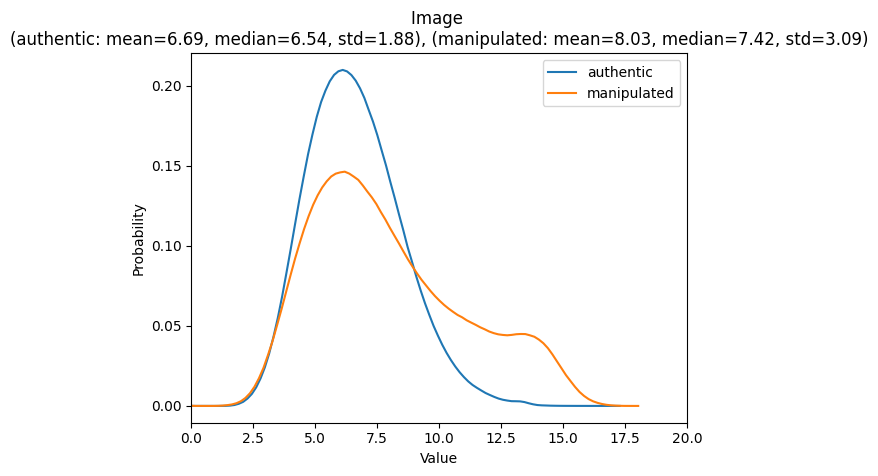

In [15]:
plot_auth_vs_manip_distrib(image_feature_distances_dict["authentic_images"], image_feature_distances_dict["manipulated_images"], title="Image")

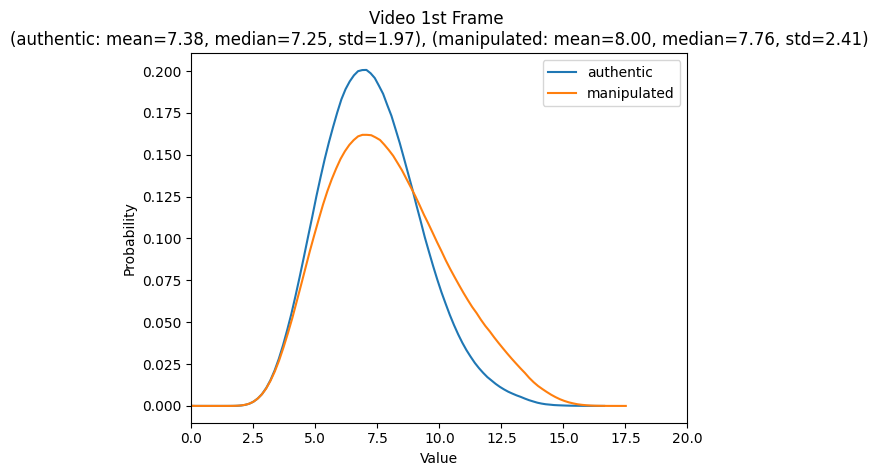

In [16]:
plot_auth_vs_manip_distrib(video_feature_distances_dict["authentic_videos_1st_frame"], video_feature_distances_dict["manipulated_videos_1st_frame"], title="Video 1st Frame")

In [17]:
# plot_auth_vs_manip_distrib(video_feature_distances_dict["authentic_videos_2nd_frame"], video_feature_distances_dict["manipulated_videos_2nd_frame"], title="Video 2nd Frame")